In [561]:
from TimeSeriesData import prepare_dataframe_for_LSTM, split_train_test, reshape_data
from TimeSeriesData import TimeSeriesDataset
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from copy import deepcopy as dc
from LSTM import LSTM, train_one_epoch, val_one_epoch, CNN_LSTM
import matplotlib.pyplot as plt
import math
from torchview import draw_graph

In [562]:
configuration = {
    "window_size": 90,
    "spliting_ratio": 0.9,
    "batch_size": 32,
    "hidden_size": 72,
    "num_layers": 3,
    "LR": 1.1e-4,
    "num_epoch": 800,
    "val_interval": 10,
    "patience": 7
}

In [563]:
stock1 = "ICE"
stock2 = "SHW"
spread = pd.read_csv(f"../data/spread/spread_{stock1}_{stock2}.csv", index_col=0)
spread.index = pd.to_datetime(spread.index)
spread.head()

,Spread
Date,
2016-01-04,0.424122
2016-01-05,0.240802
2016-01-06,0.173629
2016-01-07,0.078770
2016-01-08,0.210638


In [564]:
window_size = configuration["window_size"]
shifted_df = prepare_dataframe_for_LSTM(spread, window_size=window_size)
shifted_df.head()

,Spread,Spread(t-1),Spread(t-2),Spread(t-3),Spread(t-4),Spread(t-5),Spread(t-6),Spread(t-7),Spread(t-8),Spread(t-9),...,Spread(t-81),Spread(t-82),Spread(t-83),Spread(t-84),Spread(t-85),Spread(t-86),Spread(t-87),Spread(t-88),Spread(t-89),Spread(t-90)
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-12,0.870013,0.945821,0.903305,0.839400,0.890758,0.995801,0.851393,1.426135,1.314520,1.424735,...,0.375210,0.245544,0.318684,0.182123,0.136702,0.210638,0.078770,0.173629,0.240802,0.424122
2016-05-13,0.882553,0.870013,0.945821,0.903305,0.839400,0.890758,0.995801,0.851393,1.426135,1.314520,...,0.204683,0.375210,0.245544,0.318684,0.182123,0.136702,0.210638,0.078770,0.173629,0.240802
2016-05-16,0.916329,0.882553,0.870013,0.945821,0.903305,0.839400,0.890758,0.995801,0.851393,1.426135,...,0.524251,0.204683,0.375210,0.245544,0.318684,0.182123,0.136702,0.210638,0.078770,0.173629
2016-05-17,0.952211,0.916329,0.882553,0.870013,0.945821,0.903305,0.839400,0.890758,0.995801,0.851393,...,0.560437,0.524251,0.204683,0.375210,0.245544,0.318684,0.182123,0.136702,0.210638,0.078770
2016-05-18,0.796900,0.952211,0.916329,0.882553,0.870013,0.945821,0.903305,0.839400,0.890758,0.995801,...,0.336349,0.560437,0.524251,0.204683,0.375210,0.245544,0.318684,0.182123,0.136702,0.210638


In [565]:
shifted_df_as_np = shifted_df.values
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X = dc(np.flip(X, axis=1))
# flip the column to have Spread(t-N), Spread(t-N+1), ..., Spread(t-2), Spread(t-1)

print(X.shape, y.shape)

(2019, 90) (2019,)


In [566]:
train_proportion = configuration["spliting_ratio"]
X_train, y_train, X_test, y_test = split_train_test(X, y, train_proportion)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1817, 90) (1817,) (202, 90) (202,)


In [567]:
X_train, y_train = reshape_data(X_train, y_train, window_size=window_size)
X_test, y_test = reshape_data(X_test, y_test, window_size=window_size)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([1817, 90, 1]) torch.Size([1817, 1]) torch.Size([202, 90, 1]) torch.Size([202, 1])


In [568]:
train_set = TimeSeriesDataset(X_train, y_train)
validation_set = TimeSeriesDataset(X_test, y_test)

batch_size = configuration["batch_size"]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [569]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 90, 1]) torch.Size([32, 1])


In [570]:
lstm_model = LSTM(input_size=1, hidden_size=configuration["hidden_size"],
                  num_layers=configuration["num_layers"], device=device)
lstm_model.to(device)
lstm_model

LSTM(
  (lstm): LSTM(1, 72, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=72, out_features=1, bias=True)
)

In [571]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=configuration['LR'])
log = {
    "train_loss": [],
    "val_loss": []
}
best_val_loss = math.inf
best_model_weights = None
tolerance = configuration["patience"]

for epoch in range(1, configuration["num_epoch"]+1):
    print(f"Epoch {epoch}: ", end='')
    train_loss = train_one_epoch(lstm_model, train_loader=train_loader, optimizer=optimizer, device=device)
    log["train_loss"].append(train_loss)
    if epoch % configuration["val_interval"] == 0:
        val_loss = val_one_epoch(lstm_model, val_loader=val_loader, device=device)
        log["val_loss"].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = dc(lstm_model.state_dict())
            tolerance = configuration["patience"]
        else: # early stopping
            tolerance -= 1
            if tolerance == 0: break

lstm_model.load_state_dict(best_model_weights)
print(f"Best validation loss: {best_val_loss}")

Epoch 1: Training loss :1.006129
Epoch 2: Training loss :0.764828
Epoch 3: Training loss :0.360957
Epoch 4: Training loss :0.295025
Epoch 5: Training loss :0.251519
Epoch 6: Training loss :0.215407
Epoch 7: Training loss :0.185981
Epoch 8: Training loss :0.160865
Epoch 9: Training loss :0.147772
Epoch 10: Training loss :0.140696
Validation loss :0.131684
*************************************************
Epoch 11: Training loss :0.133211
Epoch 12: Training loss :0.125998
Epoch 13: Training loss :0.120129
Epoch 14: Training loss :0.119579
Epoch 15: Training loss :0.113880
Epoch 16: Training loss :0.113809
Epoch 17: Training loss :0.110804
Epoch 18: Training loss :0.105649
Epoch 19: Training loss :0.104634
Epoch 20: Training loss :0.103729
Validation loss :0.096219
*************************************************
Epoch 21: Training loss :0.101313
Epoch 22: Training loss :0.098513
Epoch 23: Training loss :0.099219
Epoch 24: Training loss :0.094401
Epoch 25: Training loss :0.095352
Epoch 2

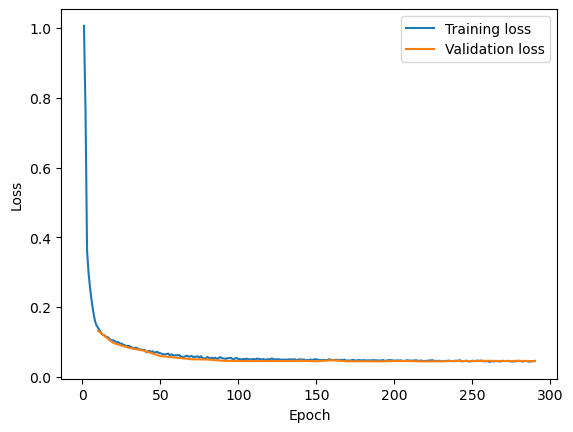

In [572]:
plt.plot(range(1, len(log["train_loss"])+1), log["train_loss"], label="Training loss")
plt.plot(range(10, len(log["train_loss"])+1, configuration["val_interval"]), log["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

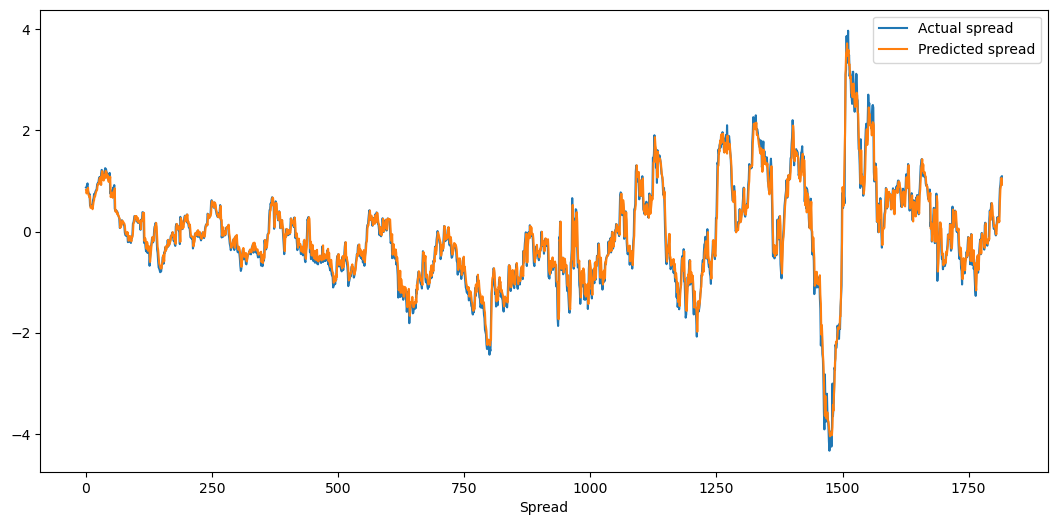

In [573]:
with torch.no_grad():
    train_predicted = lstm_model(X_train.to(device)).to('cpu').numpy()

plt.figure(figsize=(13, 6))
plt.plot(y_train, label="Actual spread")
plt.plot(train_predicted, label="Predicted spread")
plt.xlabel("Day")
plt.xlabel("Spread")
plt.legend()
plt.show()

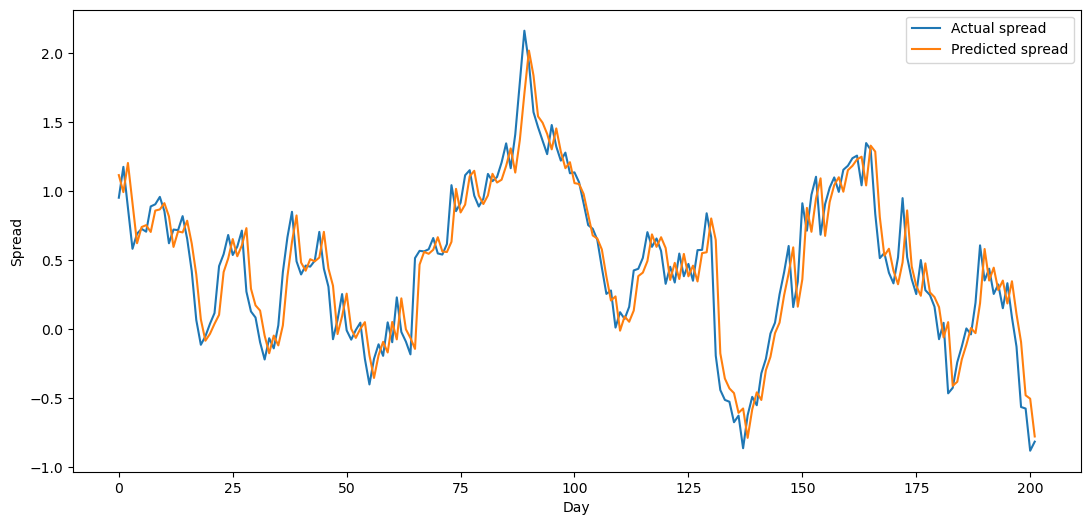

In [574]:
with torch.no_grad():
    test_predicted = lstm_model(X_test.to(device)).to('cpu').numpy()

plt.figure(figsize=(13, 6))
plt.plot(y_test, label="Actual spread")
plt.plot(test_predicted, label="Predicted spread")
plt.xlabel("Day")
plt.ylabel("Spread")
plt.legend()
plt.show()

In [575]:
torch.save(lstm_model, f"./models/LSTM_{stock1}_{stock2}.pth")

In [576]:
test_predicted_df = pd.DataFrame(test_predicted)
test_predicted_df.to_csv(f"./validation_result/LSTM_{stock1}_{stock2}.csv")